<a href="https://colab.research.google.com/github/SAHIL9581/w2w/blob/main/unet_post_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Cell 1: Setup the Simulated Project Environment
# Run this cell first to create all the necessary dummy files and folders.

import os
import torch
import torch.nn as nn

print("--- Creating simulated project structure and model files ---")

# --- 1. Create directory for model files ---
os.makedirs('models', exist_ok=True)

# --- 2. Create a dummy UNet model file: models/model_unet.py ---
# This simulates the custom UNet architecture your script imports.
unet_code = """
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # These layer names must match what your script expects
        self.start = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.encode = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.middle = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())
        # A dummy decoder to make it a "full" model
        self.decode = nn.Sequential(nn.Conv2d(64, 1, 3, padding=1))

    def forward(self, x):
        x = self.start(x)
        x = self.encode(x)
        x = self.middle(x)
        x = self.decode(x)
        return x
"""
with open("models/model_unet.py", "w") as f:
    f.write(unet_code)
print("Created dummy file: models/model_unet.py")


# --- 3. Create a dummy UNet Encoder file: models/encoder.py ---
# This simulates just the encoder part of the UNet.
encoder_code = """
import torch
import torch.nn as nn

class UNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # The layer names must match the UNet to allow weight loading
        self.start = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.encode = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.middle = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())

    def forward(self, x):
        x = self.start(x)
        x = self.encode(x)
        x = self.middle(x)
        return x
"""
with open("models/encoder.py", "w") as f:
    f.write(encoder_code)
print("Created dummy file: models/encoder.py")

print("\n--- Environment setup complete. You can now run the next cells. ---")

--- Creating simulated project structure and model files ---
Created dummy file: models/model_unet.py
Created dummy file: models/encoder.py

--- Environment setup complete. You can now run the next cells. ---


In [ ]:
### Cell 2: Run Your Model Processing Script
# This cell runs your original code to show what it does.

import torch

# These imports now work because we created the files in Cell 1
from models.model_unet import UNet
from models.encoder import UNetEncoder

# --- Block 1: Load UNet & Save Unet checkpoint ---
print("--- Part 1: Initializing and saving a full UNet model ---")
model = UNet()
image = torch.rand(1, 1, 500, 13)
output_shape = model(image).shape
print(f"Random input shape: {image.shape}")
print(f"Model output shape: {output_shape}")
torch.save(model, 'unet.pth')
print("Saved complete UNet model to 'unet.pth'")

# --- Block 2: Extract Bottleneck layer from whole UNet ---
print("\n--- Part 2: Using a hook to inspect the 'middle' layer's output ---")
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.middle.register_forward_hook(get_activation('middle'))
x = torch.rand(1, 1, 500, 13)
output = model(x)
print(f"Shape of the bottleneck activation: {activation['middle'].shape}")

# --- Block 3: Load only encoder checkpoint in encoder model ---
print("\n--- Part 3: Loading ONLY the encoder weights into a separate encoder model ---")
encoder = UNetEncoder()
checkpoint = torch.load('unet.pth', weights_only=False)

encoder_keys = ['start', 'encode', 'middle']
encoder_checkpoint = {}
for i in checkpoint.state_dict():
    for key in encoder_keys:
        if i.startswith(key):
            encoder_checkpoint[i] = checkpoint.state_dict()[i]

encoder.load_state_dict(encoder_checkpoint)
print("Successfully loaded encoder weights from 'unet.pth' into the standalone encoder model.")

print("\n--- Script finished. This shows the script's purpose is model architecture handling. ---")

--- Part 1: Initializing and saving a full UNet model ---
Random input shape: torch.Size([1, 1, 500, 13])
Model output shape: torch.Size([1, 1, 500, 13])
Saved complete UNet model to 'unet.pth'

--- Part 2: Using a hook to inspect the 'middle' layer's output ---
Shape of the bottleneck activation: torch.Size([1, 64, 500, 13])

--- Part 3: Loading ONLY the encoder weights into a separate encoder model ---
Successfully loaded encoder weights from 'unet.pth' into the standalone encoder model.

--- Script finished. This shows the script's purpose is model architecture handling. ---


--- Simulating Model Predictions and Generating Final Correlation Plot ---

Correlating common groups: {'Shetland Group', 'Utsira Formation', 'Hordaland Group'}


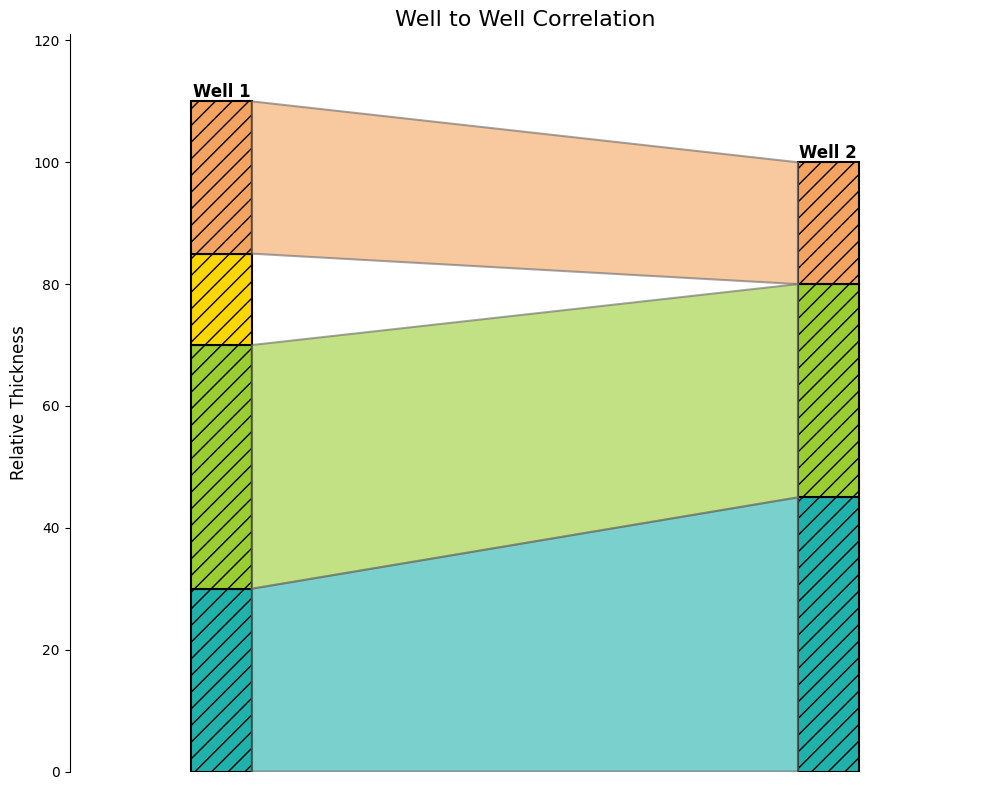

In [ ]:
### Cell 3: The Missing Visualization Step
# This cell generates the final correlation diagram based on SIMULATED model outputs.

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

print("--- Simulating Model Predictions and Generating Final Correlation Plot ---")

# --- 1. Simulate the AI Model's Output ---
# This is the data that would come from a trained model after running inference.
# The keys are the geological group names, and the values are their predicted thickness.
well_1_predictions = {
    'Utsira Formation': 25,
    'Nordland Group': 15,
    'Hordaland Group': 40,
    'Shetland Group': 30,
}

well_2_predictions = {
    'Utsira Formation': 20,
    'Hordaland Group': 35, # Note: Nordland Group is missing in this well
    'Shetland Group': 45,
}

# --- 2. Define Plotting Colors and Functions ---
group_colors = {
    'Utsira Formation': 'sandybrown',
    'Nordland Group': 'gold',
    'Hordaland Group': 'yellowgreen',
    'Shetland Group': 'lightseagreen',
    'Default': 'gray'
}

def plot_well(ax, well_data, well_name, x_position):
    """Plots a single well's predicted groups as a stacked bar."""
    current_depth = 0
    well_positions = {}
    for group, thickness in reversed(list(well_data.items())):
        color = group_colors.get(group, group_colors['Default'])
        rect = patches.Rectangle((x_position, current_depth), 0.1, thickness,
                                 facecolor=color, edgecolor='black', hatch='//', lw=1.5)
        ax.add_patch(rect)
        well_positions[group] = (current_depth, current_depth + thickness)
        current_depth += thickness
    ax.text(x_position + 0.05, current_depth, well_name,
            ha='center', va='bottom', fontsize=12, fontweight='bold')
    return well_positions, current_depth

# --- 3. Create the Main Plot and Draw Correlations ---
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the two wells
well_1_pos, total_depth_1 = plot_well(ax, well_1_predictions, "Well 1", x_position=1)
well_2_pos, total_depth_2 = plot_well(ax, well_2_predictions, "Well 2", x_position=2)

# Find common groups to draw correlation polygons
common_groups = set(well_1_pos.keys()) & set(well_2_pos.keys())
print(f"\nCorrelating common groups: {common_groups}")
for group in common_groups:
    y1_bottom, y1_top = well_1_pos[group]
    y2_bottom, y2_top = well_2_pos[group]
    polygon_coords = [[1.1, y1_bottom], [1.1, y1_top], [2.0, y2_top], [2.0, y2_bottom]]
    polygon = patches.Polygon(polygon_coords, closed=True,
                              facecolor=group_colors.get(group, 'gray'),
                              edgecolor='dimgray', alpha=0.6, lw=1.5)
    ax.add_patch(polygon)

# --- 4. Finalize and Show the Plot ---
ax.set_xlim(0.8, 2.3)
ax.set_ylim(0, max(total_depth_1, total_depth_2) * 1.1)
ax.set_title('Well to Well Correlation', fontsize=16)
ax.set_ylabel('Relative Thickness', fontsize=12)
ax.set_xticks([])
ax.spines[['top', 'right', 'bottom']].set_visible(False)
plt.tight_layout()
plt.show()